In [1]:
import copy
import pickle
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
from collections import OrderedDict
import seaborn as sns

#### Setting up the directories:

In [2]:
data_dir = 'omniglot-master/python'
background_folder = '/images_background'
evaluation_folder = '/images_evaluation'

#### Building up the alphabet dictionaries: training, validation and evaluation dicts.

In [3]:
background_alphabets_dictionary = {}
for alphabet in os.listdir(data_dir+background_folder):
    background_alphabets_dictionary[alphabet] = {char : os.listdir(data_dir+background_folder+'/'+alphabet+'/'+char) for char in os.listdir(data_dir+background_folder+'/'+alphabet)}
    
evaluation_alphabets_dictionary = {}
for alphabet in os.listdir(data_dir+evaluation_folder):
    evaluation_alphabets_dictionary[alphabet] = {char : os.listdir(data_dir+evaluation_folder+'/'+alphabet+'/'+char) for char in os.listdir(data_dir+evaluation_folder+'/'+alphabet)}
    
background_alphabets = list(background_alphabets_dictionary.keys())
evaluation_alphabets = list(evaluation_alphabets_dictionary.keys())

# Splitting up the background data to training and validation sets
validation_split = 0.3

valid_indexes = random.sample(range(0 , len(background_alphabets)), int(validation_split * len(background_alphabets)))

train_alphabets_dictionary = background_alphabets_dictionary.copy()
valid_alphabets_dictionary = {}

for i in valid_indexes:
    valid_alphabets_dictionary[background_alphabets[i]] = train_alphabets_dictionary.pop(background_alphabets[i])

#### Transforming an image into a tensor and optionally applying affline transforms:
Parameters:
- image_path : The path to the image file in the parent folder.
- training : Whether this image is for training or not. This is used to decied whether to apply affline transforms or not.
- evaluating : Whether it is for evaluation or not. This is used to choose the path to the image (background or evaluation).

###### Note: Images are resized to be 28x28 to fit my local PC resources and to reduce training time.

In [4]:
def image_transforms(image_path , training = False ,evaluating = False , data_dir = data_dir ,
                     background_folder = background_folder,evaluation_folder=evaluation_folder):
    ''' 
    Reading ,  normalizing and transforming an image.
    
    Transformations are: Random rotation +-10 degrees.
                         Random shear +-30 degrees.
                         Random rescale in range [0.8 , 1.2].
                         Random translation (0.1 ,0.1).
                         
    '''
    if not evaluating :
        img = Image.open(data_dir+background_folder+image_path) # reading the image
    else :
        img = Image.open(data_dir+evaluation_folder+image_path)
    
    if training :
        # Converting the training PIL-image into a tensor , normalizing and applying random rotation , shear , zoom and shift
        transform = transforms.Compose([transforms.RandomAffine(degrees=10, translate=(0.1,0.1),
                                                                scale=(0.8,1.2), shear=30 , fillcolor=255),
                                        transforms.Resize(28),
                                        transforms.ToTensor()
                                       ])
    else:
        # Converting the validation PIL-image into a normalized tensor
        transform = transforms.Compose([transforms.Resize(28),
                                        transforms.ToTensor()
                                       ])
    img = transform(img)
    return img

#### Visualizing The 28x28 image pixels.

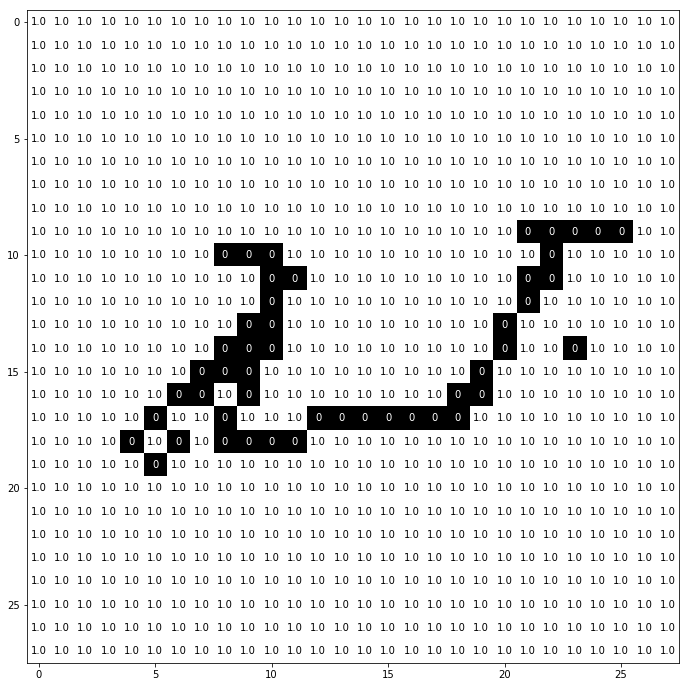

In [5]:
image = image_transforms('/Alphabet_of_the_Magi/character01/0709_01.png' , training = True ,evaluating = False )
image = image.numpy()
img = np.squeeze(image[0])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

#### Getting pairs of images and their assiciated label indicating if they are from the same characters class or not:
Parameters:
- batch_size : The size of the mini batch to be extracted in each iteration.
- training : Whether the verification batches are for training or validation (to choose the appropriate dictionary).
- same_probability : the approximate probability of the image pair being from the same class. (only for control purposes) Keeping in mind that images could be the same by random chance, hence it is an approximate probability.

Those pairs are extracted untill there are no valid image pairs left, and each image is chosen only once throughout the entire number of batches (epoch).

In [6]:
def get_verification_batches(batch_size, training = True , same_probability = 0.3 ,
                           train_alphabets_dictionary=train_alphabets_dictionary,
                           valid_alphabets_dictionary=valid_alphabets_dictionary):
    
    if training :
        alphabets_dictionary = copy.deepcopy(train_alphabets_dictionary)
    else:
        alphabets_dictionary = copy.deepcopy(valid_alphabets_dictionary)
        
    while len(alphabets_dictionary) != 0 :
        
        images = torch.tensor([]) # tensor of tensors of two [[img1 , img2], [img1 , img2] ... so on].
        labels = torch.tensor([]) # tensor of labels       [      1      ,       0       ... so on]   (1 for same, 0 for different).
        
        for i in range(batch_size):

            alphabets = list(alphabets_dictionary.keys())
            while True :
                char_1_deleted , alphabet_1_deleted = False , False
                # choosing an alphabet
                alph_index = random.randint(0 , len(alphabets)-1)
                alphabet = alphabets[alph_index]
                chars = list(alphabets_dictionary[alphabet].keys())

                # Choosing a character for image 1
                char_name_1 = chars[random.randint(0 , len(chars)-1)]
                char_imgs = alphabets_dictionary[alphabet][char_name_1]

                # Choosing image 1
                img_index_1 = random.randint(0 , len(char_imgs)-1)
                img_name_1 = char_imgs[img_index_1]
                img_1 = image_transforms('/'+alphabet+'/'+char_name_1+'/'+img_name_1 , training = training)

                # Cleaning up to elemenate redundant images in each batch, each image is chosen only once in the entire epoch
                # Deleting the selected image from list
                del alphabets_dictionary[alphabet][char_name_1][img_index_1]
                # Deleting the character dict if it is empty and updat the chars list
                if len(alphabets_dictionary[alphabet][char_name_1]) == 0:
                    del alphabets_dictionary[alphabet][char_name_1]
                    char_1_deleted = True
                    chars = list(alphabets_dictionary[alphabet].keys())
                # Deleting the alphabet dict if it is empty and update the alphabets list
                if len(alphabets_dictionary[alphabet]) == 0:
                    del alphabets_dictionary[alphabet]
                    alphabet_1_deleted = True
                    alphabets = list(alphabets_dictionary.keys())

                # Choosing a character for image 2 , with a probility ~= same_probability of being the same
                same_or_different = random.random()

                # Checking if the alphabet selected by image 1 is still available, if not then ignore this iteration
                if not alphabet_1_deleted :
                    # Checking if the character selected by image 1 is still available
                    if not char_1_deleted :
                        # when it is avalible, check for the same_probability
                        if same_or_different <= same_probability:
                            char_name_2 = char_name_1
                        else:
                            char_name_2 = chars[random.randint(0 , len(chars)-1)]
#                             # Making sure they are not the same by chance
#                             while char_name_2 == char_name_1:
#                                 char_name_2 = chars[random.randint(0 , len(chars)-1)]
                    else:
                        char_name_2 = chars[random.randint(0 , len(chars)-1)]

                    char_imgs = alphabets_dictionary[alphabet][char_name_2]

                    # Choosing image 2
                    img_index_2 = random.randint(0 , len(char_imgs)-1)
                    img_name_2 = char_imgs[img_index_2]
                    img_2 = image_transforms('/'+alphabet+'/'+char_name_2+'/'+img_name_2 , training = training)

                    # Cleaning up to elemenate redundant images in each batch, each image is chosen only once in the entire epoch
                    # Deleting the selected image from list
                    del alphabets_dictionary[alphabet][char_name_2][img_index_2]
                    # Deleting the character dict if it is empty and updat the chars list
                    if len(alphabets_dictionary[alphabet][char_name_2]) == 0:
                        del alphabets_dictionary[alphabet][char_name_2]
                        chars = list(alphabets_dictionary[alphabet].keys())
                    # Deleting the alphabet dict if it is empty and update the alphabets list
                    if len(alphabets_dictionary[alphabet]) == 0:
                        del alphabets_dictionary[alphabet]
                        alphabets = list(alphabets_dictionary.keys())

                    if char_name_1 == char_name_2 :
                        label = 1
                    else:
                        label = 0
                    
                    # Concatenating the new images and their associated label
                    images = torch.cat((images , torch.stack([img_1 , img_2] , dim =1)) , dim = 0)
                    labels = torch.cat((labels , torch.FloatTensor([[label]])) , dim =0)

                    break  # Moving on to the next iteration
                else:
#                     print("alphabet not found")
                    continue      # ignore this iteration and start again
                
            # Checking if the dictionary is empty, and breaking if it is
            if len(alphabets_dictionary) == 0:
#                 print("No more available alphabets...")
                break
                
        # Return the images and labels only if they are a full batch (last-one case covered)
        if len(images) == batch_size and len(labels) == batch_size:
            yield  images, labels

#### Getting a support set of K images, a test image and a label vector corresponding to each support set indicating whether a support set image is from the same character class of the test image or not. 
- repetitions : The number of K-way batches to be extraced.
- batch_size : How many k-way one-shot and test instances per batch.
- K : The number of the different character images in the support set.
- evaluating : Whether they are for evaluation or valdidation, it is passed on to the image_transforms function, in addition to choosing the corresponding dictionary.

All images at each instance are from the same chosen alphabet.

In [7]:
def get_K_way_batches(repetitions , batch_size = 1 ,K=20 ,evaluating = False ,
                       evaluation_alphabets_dictionary=evaluation_alphabets_dictionary,
                       valid_alphabets_dictionary=valid_alphabets_dictionary):
    
    if evaluating:
        alphabets_dictionary = copy.deepcopy(evaluation_alphabets_dictionary)
    else:
        alphabets_dictionary = copy.deepcopy(valid_alphabets_dictionary)
    
    for r in range(repetitions):
        test_images = torch.tensor([])    # tensor of test images
        support_images = torch.tensor([]) # tensor of tensors of support images [[img1 ,..., imgK], [img1 ,..., imgK] ... so on].
        labels = torch.tensor([])         # tensor of labels               [[1 , 0 , ... , 0]], [[ 0, 1 , ... , 0]]... so on].
                                          # (1 for same, 0 for different).
        for i in range(batch_size):
            images_list = []
            labels_list = []
            alphabets = list(alphabets_dictionary.keys())

            # choosing an alphabet
            alph_index = random.randint(0 , len(alphabets)-1)
            alphabet = alphabets[alph_index]
#             print(alphabet)
            chars = list(alphabets_dictionary[alphabet].keys())

            # Choosing a character for the test image
            char_name_1 = chars[random.randint(0 , len(chars)-1)]
            char_imgs = alphabets_dictionary[alphabet][char_name_1]

            # Choosing the test image
            img_index_1 = random.randint(0 , len(char_imgs)-1)
            img_name_1 = char_imgs[img_index_1]

            test_image = image_transforms('/'+alphabet+'/'+char_name_1+'/'+img_name_1 , evaluating = evaluating)

            used_chars = []
            target_there = False
            repeat = False
            # Choosing characters for the support set
            for j in range(K):
                char_name = chars[random.randint(0 , len(chars)-1)]
                while True:
                    # Making sure that each character is unique as long as there are enough characters.
                    if (char_name not in used_chars and len(used_chars) < len(chars)) or repeat:
                        # Adding the used char into the list
                        used_chars.append(char_name)

                        # Choosing a character drawing (image)
                        char_imgs = alphabets_dictionary[alphabet][char_name]
                        img_index = random.randint(0 , len(char_imgs)-1)
                        img_name = char_imgs[img_index]

                        image = image_transforms('/'+alphabet+'/'+char_name+'/'+img_name , evaluating = evaluating)

                        if char_name_1 == char_name :
                            label = 1
                            target_there = True
                        else:
                            label = 0

                        images_list.append(image)
                        labels_list.append(label)

                        repeat = False
                        # making sure that there is a true labeled character
                        if len(used_chars) == K and not target_there:
                            char_name = char_name_1
                            # replacing the last one with the true instance
                            del images_list[-1]
                            del labels_list[-1]
                            repeat = True
                            continue
                        break
                    # Choosing again while there is room for more
                    elif char_name in used_chars and len(used_chars) < len(chars) :
                        char_name = chars[random.randint(0 , len(chars)-1)]
                        continue

                    elif len(used_chars) >= len(chars):
                        # Checking if the alphabet has characters less than K
                        missing = K - len(used_chars)
                        if missing > 0 :
                            repeat = True
                            while True:
                                char_name = chars[random.randint(0 , len(chars)-1)]
                                if char_name != char_name_1:
                                    break
                            continue

            # Concatenating the new images and their associated label
            test_images = torch.cat((test_images, test_image), dim = 0)
            support_images = torch.cat((support_images , torch.stack(images_list , dim =1)) , dim = 0)
            labels = torch.cat((labels , torch.FloatTensor([labels_list])) , dim =0)
        
        yield  test_images, support_images, labels


### Training function
- model : A model instance.
- optimizer : An optimizer instance.
- scheduler_cycle :  The starting cycle-length for the cosine scheduler.
- n_epochs : The number of epochs.
- one_shot_repetitions :The number of K-way batches to be extraced for one shot testing.
- max_accuracy : Maximum one-shot accuracy scored during validation.
- MODEL : The name of the model to be saved with.

Returns the maximum  one-shot accuracy scored, in addition to 5 lists corresponding to the progress of losses and accuracies accross the training epochs.

#### Cosine Annealing Scheduler for the SGDR:
Refering to the [article](https://medium.com/38th-street-studios/exploring-stochastic-gradient-descent-with-restarts-sgdr-fa206c38a74e) and the [paper](https://arxiv.org/pdf/1608.03983.pdf), this method has shown effectiveness in finding a stable "hopefully global" minima after a substantial amount of epochs.
I have chosen to use a variable cycle-length throughout the training process via increasing the cycle-length by 25% after each cycle.

In [8]:
def Train_One_Shot_Model(model, optimizer , scheduler_cycle, n_epochs, batch_size, one_shot_repetitions,
                         max_accuracy, MODEL='Siamese_Network'):
    
    train_loss = []
    verif_loss = []
    one_shot_loss = []
    verification_accuracy = []
    one_shot_accuracy = []
    # for the SGDR's restarts
    cycle_restart = True
    cycle_begun = 0
  
    for epoch in range(1, n_epochs+1):
        
        if (epoch-1) == (cycle_begun+scheduler_cycle):
            cycle_restart = True
            
        if cycle_restart :
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, scheduler_cycle) # restarting
            print('Cycle Started..')
            scheduler_cycle = int(1.25 * scheduler_cycle)  # increasing the next cycle by 25%
            cycle_restart = False
            cycle_begun = epoch-1

        scheduler.step()

        epoch_train_loss = []
        epoch_verif_loss = []
        epoch_one_shot_loss = []
        epoch_verification_accuracy = []
        epoch_one_shot_accuracy = []

        ######################
        # Training the model #
        ######################
        siamese_network.train()
        training_iterations = 0
        for images, labels in get_verification_batches(batch_size, training = True):
            training_iterations +=1
            images, labels = images.cuda(), labels.cuda()

            optimizer.zero_grad() # Clearing the gradients of all optimized variables

            # Passing in the images with an addtional dimention for the network to work -> images.shape = (batch_size,1,105,105)
            output = model(images[:,0,:,:].unsqueeze(1),images[:,1,:,:].unsqueeze(1))

            loss = criterion(output, labels[:,0].long()) # Calculating the batch loss
            loss.backward() # Computing the loss gradients with respect to model parameters
            optimizer.step() # Updating parameters
            epoch_train_loss.append(loss.item()) # Adding the mean batch training loss
            # Cleaning gpu by moving variables back to cpu to be overridden
            images, labels, output = images.cpu(), labels.cpu(), output.cpu()


        ########################  
        # Validating the model #
        ########################
        siamese_network.eval()
        with torch.no_grad():
            # Verification #
            validation_iterations = 0
            for images, labels in get_verification_batches(batch_size, training = False):
                validation_iterations +=1
                images, labels = images.cuda(), labels.cuda()

                # Passing in the images with an addtional dimention for the network to work -> images.shape = (batch_size,1,105,105)
                output = model(images[:,0,:,:].unsqueeze(1),images[:,1,:,:].unsqueeze(1))
                loss = criterion(output, labels[:,0].long()) # Calculating the batch loss
                epoch_verif_loss.append(loss.item()) # Adding the mean batch training loss
                # Calcualting the validation accuracy
                _, pred = torch.max(torch.exp(output), 1)
                accuracy = (labels[:,0].long() == pred).float().mean()
                epoch_verification_accuracy.append(accuracy.item())
                # Cleaning gpu by moving variables back to cpu to be overridden
                images, labels, output = images.cpu(), labels.cpu(), output.cpu()

            # 20-way One_Shot validation
            for image , support_set , labels in get_K_way_batches(one_shot_repetitions,batch_size,K=20 , evaluating = False ):
                image, support_set, labels = image.cuda(), support_set.cuda(), labels.cuda()
                output = model.One_Shot_Classify(image, support_set, K=20)
                loss = criterion(output, (labels==1).nonzero()[:,1]) # Calculating the loss
                scheduler.step(loss)
                epoch_one_shot_loss.append(loss.item()) # Adding the mean training loss
                _, pred = torch.max(torch.exp(output), 1)
                accuracy = (pred.eq((labels==1).nonzero()[:,1]).float()).mean()
                epoch_one_shot_accuracy.append(accuracy.item())
                # Cleaning gpu by moving variables back to cpu to be overridden
                image, support_set, labels, output = image.cpu(), support_set.cpu(), labels.cpu(), output.cpu()


        # calculate average losses and accuracies accross the epoch
        train_loss.append(np.mean(epoch_train_loss))
        verif_loss.append(np.mean(epoch_verif_loss))
        one_shot_loss.append(np.mean(epoch_one_shot_loss))
        verification_accuracy.append(np.mean(epoch_verification_accuracy))
        one_shot_accuracy.append(np.mean(epoch_one_shot_accuracy))

        # Monitoring training and validation progress 
        print('{:3d} Training Loss: {:.3f}  Verification Loss: {:.3f}  One-Shot Loss: {:.3f}  Verification Acc: {:.3f}  One_Shot Acc: {:.3f}'.format(
            epoch, train_loss[-1], verif_loss[-1], one_shot_loss[-1] ,verification_accuracy[-1], one_shot_accuracy[-1]))

        # saving the model if one-shot validation accuracy has increased
        if one_shot_accuracy[-1] >= max_accuracy:
            print('\t\tOne-Shot accuracy increased ({:.6f} --> {:.6f}).  Model Saved !'.format(max_accuracy,one_shot_accuracy[-1]))
            torch.save(model.state_dict(), MODEL+'.pt')
            max_accuracy = one_shot_accuracy[-1]
        
    return max_accuracy, train_loss, verif_loss, one_shot_loss , verification_accuracy, one_shot_accuracy

### Defining the Siamese Network Model : 

Since the images are resized to be 28x28, the convnet architecture used here is different from the network defined in the [paper](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf).

The convolutional layers are : 
- Layer 1 :
    - conv1 : 1 input channel, 32 output channels, 3x3 filters, 1 stride and 0 padding.  ===> Resulting in a 32x26x26 output.
- Layer 2 :
    - conv2 : 32 input channel, 64 output channels, 3x3 filters, 1 stride and 0 padding. ===> Resulting in a 64x24x24 output.
    - max pooling : 2x2 filter.  ===> Resulting in a 64x12x12 output.

The fully-connected layers are:
- Layer 1 : 9216 inputs and 4096 outputs.
- Layer 2 : 4096 inpus and 2 outputs.
    - The output of the network was modified to have two neurons instead of one neuron which makes it a two-class classification problem, the first class is "different" and the second is "the same".
    
For regularization, a dropout layer with a probability of 0.25 is used before the fully-connected layers.

In [9]:
class Siamese_Network(nn.Module):
    
    def __init__(self ):
        super(Siamese_Network, self).__init__()
        
        self.conv1 = nn.Conv2d(1,32,3)
        self.conv2 = nn.Conv2d(32,64,3)
        self.pool = nn.MaxPool2d(2, 2) 
        self.fc1 = nn.Linear(9216, 4096)
        self.fc2 = nn.Linear(4096, 2)
        self.dropout = nn.Dropout(0.25)
        

    def img_forward(self, x):
        # embedding an image
        
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = self.dropout(self.pool(out))

        out = out.view(out.shape[0], -1)
        out = torch.sigmoid(self.fc1(out))
        return out

    def forward(self, x1, x2):

        # encoding the image pairs
        h1 = self.img_forward(x1)
        h2 = self.img_forward(x2)
        
        # computing the distance
        diff = torch.abs(h1 - h2)
        scores = self.fc2(diff)
        return scores
    
    def One_Shot_Classify(self, images, support_images, K=20):
        scores = []
        # computing the score for the kth images and the test images in the entire batch
        for k in range(K):
            score = self.forward(images.unsqueeze(1),support_images[:,k,:,:].unsqueeze(1))
            # the scores here are constructed such that the shape is Kxbatch_size
            scores.append(torch.log_softmax(score,dim=1)[:,1])
        # fixing the shape of the scores to be batch_sizexK
        scores = torch.stack(scores).t()
        return scores

In [10]:
# initializing the network, loss function and optimizer

siamese_network = Siamese_Network()
siamese_network.cuda()

# specifying the loss function to be catigorical cross entropy loss
criterion = nn.CrossEntropyLoss()
# specifying the optimizer to be stochastic gradient descent, with a cycle starting learning-rate of 0.1 .
optimizer = optim.SGD(siamese_network.parameters(),lr=0.1, momentum=0.9)

##### Starting the training process
I have chosen the starting cycle-length to be 10, and the number of epochs to be 1810.

Therefore, the cosine scheduler restarts at epochs :
0, 12, 27, 45, 67, 94, 127, 168, 219, 282, 360, 457, 578, 729, 917, 1152 and 1445.

In [ ]:
max_accuracy, train_loss, verif_loss, one_shot_loss, verification_accuracy, one_shot_accuracy = Train_One_Shot_Model(
                                                                                siamese_network, optimizer, scheduler_cycle = 10,
                                                                                n_epochs=1810, batch_size = 128,
                                                                                one_shot_repetitions = 100, max_accuracy=0.1,
                                                                                MODEL='Siamese_Network_2out_28x28_fully-trained')

_To skip the unnessecary endless epochs (which took me 4 and a half days!), the output was cleared._

The maximum one-shot accuracy was scored at epoch 1190 with:

        Training Loss: 0.225  Verification Loss: 0.237  One-Shot Loss: 1.184  Verification Acc: 0.905  One_Shot Acc: 0.732

After training, the metrics (losses and accuracies) were saved in "Training_Progress_28x28_SGDR_fully-trained.pkl"

In [11]:
with open('Training_Progress_28x28_SGDR_fully-trained.pkl', "rb") as f:
    verif_loss, one_shot_loss, train_loss, verification_accuracy, one_shot_accuracy = pickle.load(f) 

#### Visualizing the training progress
The vertical lines indicate when the cycles were restarted.

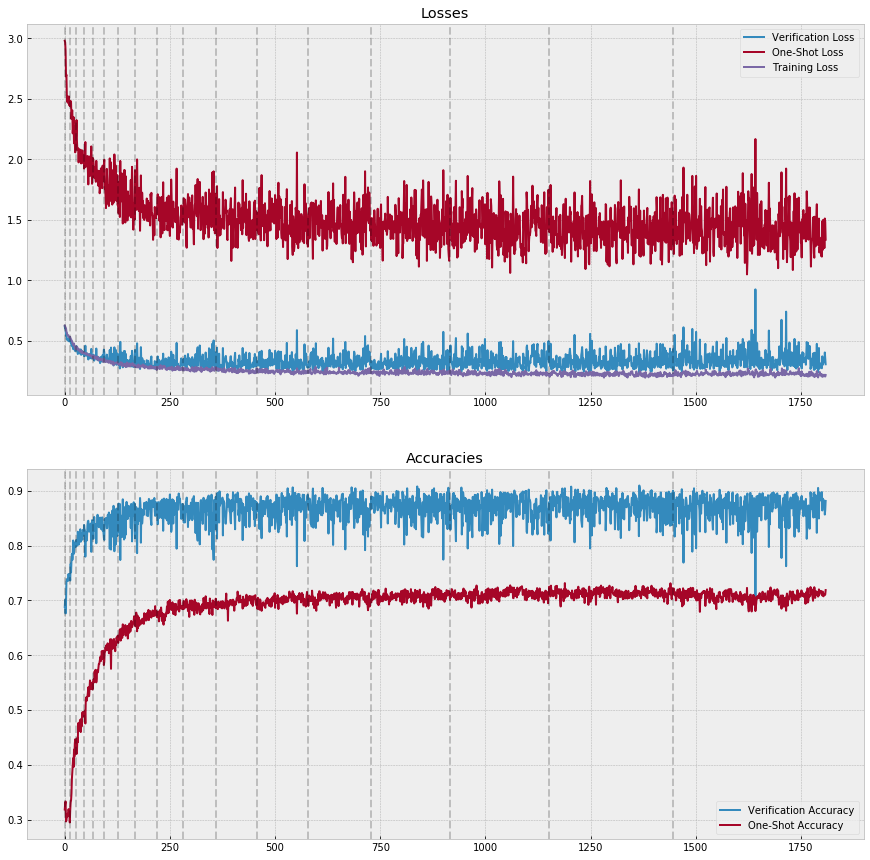

In [12]:
restarts = [0, 12, 27, 45, 67, 94, 127, 168, 219, 282, 360, 457, 578, 729, 917, 1152, 1445]
plt.style.use('bmh')
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.title('Losses')
plt.plot(verif_loss , label = 'Verification Loss',)
plt.plot(one_shot_loss , label = 'One-Shot Loss')
plt.plot(train_loss , label = 'Training Loss')
for xc in restarts:
    plt.axvline(x=xc, color='k',alpha = 0.2, linestyle='--')
plt.legend(loc='best')

plt.subplot(2,1,2)
plt.title('Accuracies')
plt.plot(verification_accuracy , label = 'Verification Accuracy')
plt.plot(one_shot_accuracy , label = 'One-Shot Accuracy')
for xc in restarts:
    plt.axvline(x=xc, color='k',alpha = 0.2, linestyle='--')
plt.legend(loc='best')
plt.show()

In [13]:
# Reloading the best model found.
siamese_network.load_state_dict(torch.load('Siamese_Network_2out_28x28_fully-trained.pt'))

## Evaluation :

Using my own "greedy" one-shot trials:

In [14]:
eval_one_shot_loss = []
eval_one_shot_accuracy = []

siamese_network.eval()
with torch.no_grad():
    # 20-way One_Shot evaluation
    for image , support_set , labels in get_K_way_batches(repetitions = 200, batch_size=128 ,K=20 , evaluating = True ):
        image, support_set, labels = image.cuda(), support_set.cuda(), labels.cuda()
        output = siamese_network.One_Shot_Classify(image, support_set, K=20)
        loss = criterion(output, (labels==1).nonzero()[:,1]) # Calculating the loss
        eval_one_shot_loss.append(loss.item()) # Adding the mean training loss
        _, pred = torch.max(torch.exp(output), 1)
        accuracy = (pred.eq((labels==1).nonzero()[:,1]).float()).mean()
        eval_one_shot_accuracy.append(accuracy.item())
        # Cleaning
        image, support_set, labels, output = image.cpu(), support_set.cpu(), labels.cpu(), output.cpu()
    
print("Evaluation Loss = {:.3f}\t\t\t Evaluation Accuracy = {:.3f} +-{:.3f}".format(np.mean(eval_one_shot_loss),np.mean(eval_one_shot_accuracy),np.std(eval_one_shot_accuracy)))

Evaluation Loss = 1.119			 Evaluation Accuracy = 0.730 +-0.038


#### Prediction insight :

Index of the chosen image :  19


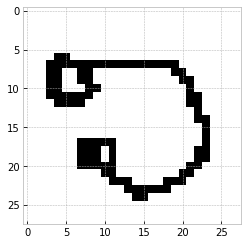

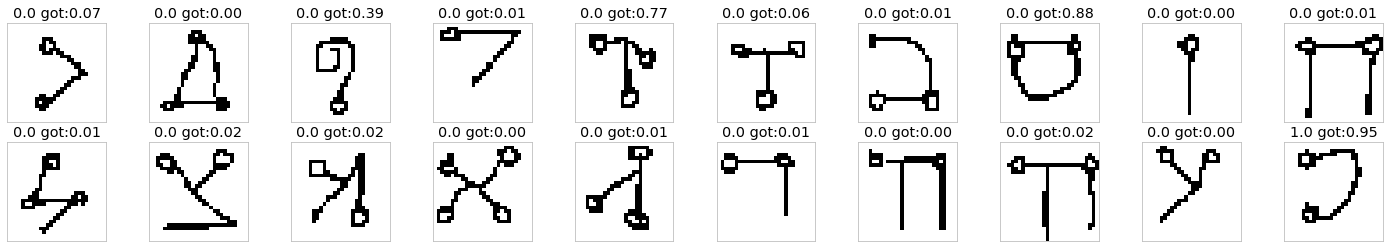

In [15]:
test_images, support_images, labels = next(iter(get_K_way_batches(1,K=20 ,evaluating = True )))

output =siamese_network.One_Shot_Classify(test_images.cuda(), support_images.cuda(), K=20)
_, pred = torch.max(output, 1)
print('Index of the chosen image : ' , pred.item())

i = 0
im = test_images[i]
im = np.array(im)
plt.imshow(np.squeeze(im), cmap='gray')

fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.array(support_images[i,idx]), cmap='gray')
    ax.set_title(str((labels[i][idx]).item())+' got:{:.2f}'.format((torch.exp(output)[i][idx]).item()))

##### Using the setup runs available with the dataset :

In [16]:
siamese_network.cpu()
siamese_network.eval()

folder = 'omniglot-master/python/one-shot-classification'
transform = transforms.Compose([transforms.Resize(28),transforms.ToTensor()])
total_accuracy = []

for i in range(1 , 21):
    run_accuracy = 0.0
    
    rs = str(i)
    if len(rs)==1:
        rs = '0' + rs
    with open(folder+'/run'+rs+'/class_labels.txt') as f:
        content = f.read().splitlines()   
    pairs = [line.split() for line in content]
    test_files  = [pair[0] for pair in pairs]
    train_files = [pair[1] for pair in pairs]
    answers_files = copy.copy(train_files)
    test_files.sort()
    train_files.sort()
    ntrain = len(train_files)
    ntest = len(test_files)
    
    # Setting up the support set in a [1 , 20 , 105 , 105]-shaped tensor.
    support_images = torch.tensor([])
    for train_file in train_files:
        img = Image.open(folder+'/'+train_file)
        img = transform(img)
        support_images = torch.cat((support_images , img) , dim=0)
    support_images=support_images.unsqueeze(0)
    # Getting a test image and turning it into a [1 , 105 , 105]-shaped tensor
    for (j , test_file) in enumerate(test_files):
        test_image = Image.open(folder+'/'+test_file)
        test_image = transform(test_image)
        
        # Predict the class of the test image from the support images
        output = siamese_network.One_Shot_Classify(test_image, support_images, K=20)
        _, pred = torch.max(torch.exp(output), 1)
        if train_files[pred.item()] == answers_files[j]:
            run_accuracy += 1.0
    run_accuracy = 100 * run_accuracy / ntest
    total_accuracy.append(run_accuracy)
    
    print (" run" + rs + "\t Error :" + str(100-run_accuracy) + "% \t Accuracy :" + str(run_accuracy) + '%')
print (" Average Error : " + str(100 - np.mean(total_accuracy)) + "%" + '\t Average Accuracy : '+ str(np.mean(total_accuracy)) + "%" )

 run01	 Error :0.0% 	 Accuracy :100.0%
 run02	 Error :10.0% 	 Accuracy :90.0%
 run03	 Error :10.0% 	 Accuracy :90.0%
 run04	 Error :5.0% 	 Accuracy :95.0%
 run05	 Error :15.0% 	 Accuracy :85.0%
 run06	 Error :15.0% 	 Accuracy :85.0%
 run07	 Error :10.0% 	 Accuracy :90.0%
 run08	 Error :20.0% 	 Accuracy :80.0%
 run09	 Error :25.0% 	 Accuracy :75.0%
 run10	 Error :30.0% 	 Accuracy :70.0%
 run11	 Error :10.0% 	 Accuracy :90.0%
 run12	 Error :10.0% 	 Accuracy :90.0%
 run13	 Error :10.0% 	 Accuracy :90.0%
 run14	 Error :15.0% 	 Accuracy :85.0%
 run15	 Error :5.0% 	 Accuracy :95.0%
 run16	 Error :5.0% 	 Accuracy :95.0%
 run17	 Error :20.0% 	 Accuracy :80.0%
 run18	 Error :15.0% 	 Accuracy :85.0%
 run19	 Error :10.0% 	 Accuracy :90.0%
 run20	 Error :0.0% 	 Accuracy :100.0%
 Average Error : 12.0%	 Average Accuracy : 88.0%
